# Modelleri Kaydetme ve Yükleme

Bu başlık altında, eğitilmiş bir modeli nasıl alıp kaydedebileceğimizi ve sonra modeli eğitmeye devam etmek için nasıl geri yükleyebileceğimizi anlamaya çalışalım. Önceki colab dosyasındaki gibi kedi ve köpeklerin görüntülerini sınıflandırmak için bir sınıflandırıcı oluşturmak için aktarımlı öğrenme yapacağız. Daha sonra eğitimli modelimizi alıp Keras tarafından kullanılan HDF5 formatında dosya olarak kaydedeceğiz. Daha sonra ise bu modeli geri yükleyip tahminlerde bulunacağız ve modeli eğitmeye kaldığımız yerden devam edeceğiz. Son olarak, eğitilmiş modelimizi bir TensorFlow `SavedModel` olarak kaydedeceğiz. En son aşamada ise farklı platformlarda dağıtım için kullanılabilecek şekilde diske indireceğiz.

## Bu Başlık Altında Ele Alınan Konular

1. Modellerin Keras için HDF5 formatında kaydedilmesi
2. Modellerin TensorFlow `SavedModel` biçiminde kaydedilmesi
3. Modellerin yüklenmesi
4. Modellerin yerel diske indirilmesi.

Bu Colab dosyasını başlatmadan önce yukarıdaki menüden `Çalışma zamanı -> Çalışma Zamanını Yeniden Başlat ...` seçeceğini seçerken colab ortamını sıfırlamalısınız.

## Paketlerin İçe Aktarılması

Bu colab dosyasında TensorFlow 2.0 Beta versiyonu kullanılmıştır.

In [1]:
!pip install -U tensorflow_hub
!pip install -U tensorflow_datasets

     |████████████████████████████████| 3.9 MB 11.4 MB/s 
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1


Daha önceden aşina olduğumuz paketlerin içeri aktarılması.

In [2]:
import time
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tensorflow.keras import layers

## Bölüm 1: Dogs vs Cats Veri Setinin Yüklenmesi

Bu veri setini indirmek için `TensorFlow Datasets` kullanıyoruz.

In [3]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


Dogs vs. Cats veri setindeki resimlerin hepsi aynı boyutta değildir. Bu nedenle, tüm görüntüleri MobileNet tarafından beklenen 224 x 224 çözünürlüğe yeniden biçimlendirelim.

In [4]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return  image, label

num_examples = info.splits['train'].num_examples

BATCH_SIZE = 32
IMAGE_RES = 224

train_batches      = train_examples.cache().shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.cache().map(format_image).batch(BATCH_SIZE).prefetch(1)

## Bölüm 2: TensorFlow Hub ile Transfer Öğrenimi

Aktarım (transfer) öğrenimi için `TensorFlow Hub` kullanalım.

In [5]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

Özellik çıkarıcı (`feature_extractor`) katmanındaki değişkenleri donduralım, böylece eğitim yalnızca son sınıflandırıcı katmanında gerçekleşir.

In [6]:
feature_extractor.trainable = False

### Sınıflandırma Başlığının Eklenmesi

Şimdi `hub` katmanını bir `tf.keras.Sequential` modeli ile sarıyoruz ve bir sınıflandırıcı katman ekliyoruz.

In [7]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


### Modelin Eğitilmesi

Sırada `compile` ile modelimizin derlenmesi ve `fit` ile eğitimin başlatılması var.

In [8]:
model.compile(
  optimizer='adam', 
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 3
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/3
582/582 [==============================] - 251s 423ms/step - loss: 0.0570 - accuracy: 0.9796 - val_loss: 0.0305 - val_accuracy: 0.9890
Epoch 2/3
582/582 [==============================] - 236s 406ms/step - loss: 0.0296 - accuracy: 0.9900 - val_loss: 0.0302 - val_accuracy: 0.9893
Epoch 3/3
582/582 [==============================] - 240s 413ms/step - loss: 0.0250 - accuracy: 0.9916 - val_loss: 0.0324 - val_accuracy: 0.9888


### Tahminlere Bakılması

Sınıf adlarının sıralı listesini alalım.

In [9]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

Model üzerinden bir görüntü grubu alalım ve indeksleri sınıf adlarına dönüştürelim.

In [10]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat',
       'cat', 'dog', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat',
       'dog', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat',
       'dog', 'dog', 'cat', 'cat', 'cat'], dtype='<U3')

Gerçek etiketlere (*label*) ve tahmin edilenlere bakalım.

In [11]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [0 0 1 0 1 1 1 0 0 1 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 0 0 1 1 0 0 1]
Predicted labels:  [0 0 1 0 1 1 1 0 0 0 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 0 0 1 1 0 0 0]


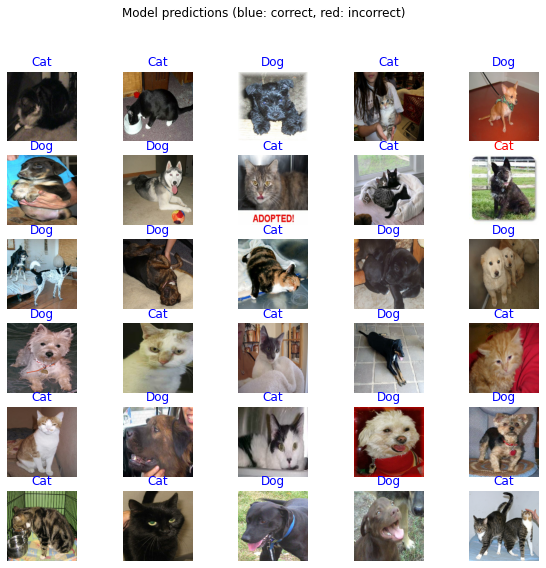

In [12]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

## Bölüm 3: Modelin Keras `.h5` Formatında Kaydedilmesi

Artık modeli eğittiğimize göre, onu Keras tarafından kullanılan format olan HDF5 dosyası olarak kaydedebiliriz. HDF5 dosyamızın uzantısı `.h5` uzantısına sahip olacak ve adı geçerli zaman damgasına karşılık gelecek şekilde atanacaktır.

In [13]:
t = time.time()

export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

./1627293290.h5


In [14]:
!ls

1627293290.h5  sample_data


Modeli oluşturan koda artık erişiminiz olmasa bile, daha sonra bu dosyadan aynı modeli yeniden oluşturabilirsiniz.

Bu dosya şunları içermektedir:

- Modelin mimarisini
- Modelin ağırlık değerlerini (Eğitim sırasında öğrenilen değerler)
- Varsa modelin eğitim yapılandırması (Derleme zamanında iletilen değerler)
- Optimize edici ve varsa durumu (Bunun sayesinde bir eğitime kaldığınız yerden devam edebilirsiniz.)

## Bölüm 4: Modelin Keras `.h5` Formatına Yüklenmesi

Şimdi teni kaydettiğimiz modeli `reloaded` adlı yeni bir modele yükleyelim. Dosya yolunu ve `custom_object` parametresini sağlamamız gerekiyor. Bu parametre, keras'a aktarım öğrenmesi için kullandığımız `feature_extractor`'dan `hub.KerasLayer`'ın nasıl yükleneceğini belirtir.

In [15]:
reloaded = tf.keras.models.load_model(
  export_path_keras, 
  # `custom_objects` kerasa `hub.KerasLayer`'ı nasıl yükleyeceğimizi söyler
  custom_objects={'KerasLayer': hub.KerasLayer})

reloaded.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


Yeniden yüklenen modelin ve önceki modelin aynı sonucu verip vermediğini kontrol edelim.

In [16]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

Çıktıların farkı sıfır olmalıdır.

In [17]:
(abs(result_batch - reloaded_result_batch)).max()

0.0

Görüldüğü gibi sonuç `0.0` dır. Bu her iki modelin de aynı görüntü yığını üzerinde aynı tahminleri yaptığı içindir.

### Eğitime Kaldığı Yerden Devam Edilmesi

Tahminler yapmanın yanı sıra yeniden yüklenen modelimizi alıp eğitmeye kaldığı yerden devam edebiliriz. Bunu yapmak için yeniden yüklenen modeli her zamanki gibi `fit` yöntemi ile eğitiyoruz.

In [18]:
EPOCHS = 3
history = reloaded.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/3
582/582 [==============================] - 272s 464ms/step - loss: 0.0218 - accuracy: 0.9925 - val_loss: 0.0297 - val_accuracy: 0.9910
Epoch 2/3
582/582 [==============================] - 271s 466ms/step - loss: 0.0201 - accuracy: 0.9931 - val_loss: 0.0388 - val_accuracy: 0.9884
Epoch 3/3
582/582 [==============================] - 272s 467ms/step - loss: 0.0166 - accuracy: 0.9949 - val_loss: 0.0352 - val_accuracy: 0.9888


## Bölüm 5: Modelin `SavedModel` Formatında Kaydedilmesi

Bununla beraber modeli TensorFlow `SavedModel` formatına aktarabiliriz. SavedModel, TensorFlow hizmetinin yanı sıra Python dışındaki TensorFlow uygulamaları tarafından desteklenen TensorFlow nesneleri için bağımsız bir serileştirme biçimidir. SavedModel, ağırlıklar ve hesaplamalar dahil olmak üzere eksiksiz bir TensorFlow programı içerir. Çalıştırmak için orijinal model oluşturma kodunu gerektirmez, bu da onu paylaşım veya dağıtım için faydalı kılar (TFlite, TensorFlow.js, TensorFlow Serving veya TFHub ile).

Oluşturulan bir SavedModel dosyaları şunları içermektedir:

- Model ağırlıklarını içeren bir TensorFlow kontrol noktası.
- Temeldeki TensorFlow grafiğini içeren bir SavedModel protokolü. Tahmin, eğitim ve değerlendirme için ayrı grafikler kaydeder. Model daha önce derlenmişse, yalnızca çıkarım grafiğini dışarı aktarır.
- Varsa modelin mimari yapılandırılması.

Orijinal modelimizi TensorFlow SavedModel olarak kaydedelim. Bunu yapmak için `tf.saved_model.save()` işlevini kullanırız. Bu işlev, kaydetmek istediğimiz modeli ve modelimizi kaydetmek istediğimiz klasör yolunu parametre olarak bekler.

Bu fonksiyon, `assets`, `variables` klasörleri ve `save_model.pb` dosyası oluşturacaktır.

In [19]:
t = time.time()

export_path_sm = "./{}".format(int(t))
print(export_path_sm)

tf.saved_model.save(model, export_path_sm)

./1627294470

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: ./1627294470/assets


INFO:tensorflow:Assets written to: ./1627294470/assets


In [20]:
!ls {export_path_sm}

assets	saved_model.pb	variables


## Bölüm 6: SavedModel'in Yüklenmesi

Şimdi SavedModel'i geri yükleyelim ve tahminler yapmak için kullanalım. SavedModel'i yüklemek için `tf.saved_model.load()` fonksiyonunu kullanırız. Bu fonksiyon tarafından döndürülen nesne, onu oluşturan kodlardan %100 bağımsızdır.


In [21]:
reloaded_sm = tf.saved_model.load(export_path_sm)

Şimdi, bir grup görüntü üzerinde tahminler yapmak için `reloaded_sm` kullanalım.

In [22]:
reload_sm_result_batch = reloaded_sm(image_batch, training=False).numpy()

Yeniden yüklenen SavedModel ile önceki modelimizin aynı sonucu verdiğini kontrol edebiliriz.

In [23]:
(abs(result_batch - reload_sm_result_batch)).max()

0.0

Görüldüğü gibi sonuç `0.0` dır. Bu her iki modelin de aynı görüntü yığını üzerinde aynı tahminleri yaptığı içindir.

## Bölüm 7: SavedModel'in Keras Modeli Olarak Yüklenmesi

`tf.saved_model.load` işlevi tarafından döndürülen nesne bir keras nesnesi değildir (yani `.fit`,`.predict`,`.summary` gibi yöntemlere sahip değil). Bu nedenle `reloaded_sm` modelimizi alıp `.fit` ile eğitmeye devam edemeyiz. TensorFlow SavedModel formatından tam bir keras modeline geri alabilmek için `tf.keras.models.load_model` işlevini kullanmalıyız. Bu işlev öncekiyle aynı şekilde çalışacaktır ancak bu sefer SavedModel'i içeren klasörün yolunu iletmemiz gerekir.

In [24]:
t = time.time()

export_path_sm = "./{}".format(int(t))
print(export_path_sm)
tf.saved_model.save(model, export_path_sm)

./1627294478

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: ./1627294478/assets


INFO:tensorflow:Assets written to: ./1627294478/assets


In [25]:
reload_sm_keras = tf.keras.models.load_model(
  export_path_sm,
  custom_objects={'KerasLayer': hub.KerasLayer})

reload_sm_keras.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


Şimdi, bir dizi görüntü üzerinde tahminler yapmak için `reloaded_sm_leras`modelimizi kullanalım.

In [26]:
result_batch = model.predict(image_batch)
reload_sm_keras_result_batch = reload_sm_keras.predict(image_batch)

Yeniden yüklenen Keras modelinin ve önceki modelin aynı sonucu verdiğini kontrol edebiliriz.

In [27]:
(abs(result_batch - reload_sm_keras_result_batch)).max()

0.0

## Bölüm 8: Modelimizin İndirilmesi


Bir zip dosyası oluşturarak SavedModel'i yerel diskinize indirebilirsiniz. Tüm alt klasörleri sıkıştırmak için `-r` (recursice) seçeneğini kullanabiliriz.

In [28]:
!zip -r model.zip {export_path_sm}

  adding: 1627294478/ (stored 0%)
  adding: 1627294478/variables/ (stored 0%)
  adding: 1627294478/variables/variables.index (deflated 78%)
  adding: 1627294478/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: 1627294478/assets/ (stored 0%)
  adding: 1627294478/saved_model.pb (deflated 91%)


Zip dosyası geçerli çalışma dizinimize kaydedilir. Mevcut çalışma dizininde neler olduğuna aşağıdaki kod bloğunu çalıştırarak görebiliriz.

In [29]:
!ls

1627293290.h5  1627294470  1627294478  model.zip  sample_data


Dosya sıkıştırıldıktan sonra yerel diskimize indirebiliriz.

In [30]:
try:
  from google.colab import files
  files.download('./model.zip')
except ImportError:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

`files.download` komutu mevcut çalışma dizinindeki dosyaları arayacaktır. İndirmek istediğiniz dosya mevcut çalışma dizini dışında başka bir dizindeyse, dosyalnın bulunduğu dizini eklemeyi unutmayın